# Memory 2 Heterogeneous Agents

### Setup

In [70]:
from pyCRLD.Environments.Base import ebase

from fastcore.utils import *
from fastcore.test import *

from pyCRLD.Environments.MultipleObsSocialDilemma import MultipleObsSocialDilemma

from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Utils import FlowPlot as fp

from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded, ObsActHistsIx, hOset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def generate_obs_matrix_from_obs_set(descriptions):
    num_states = len(descriptions)  # Total number of states
    matrix = np.zeros((num_states, num_states))  # Initialize the observation matrix

    # Iterate over each description for both observed and comparing state
    for i, observed_desc in enumerate(descriptions):
        observed_parts = observed_desc.strip('|').split(',')
        for j, comparing_desc in enumerate(descriptions):
            comparing_parts = comparing_desc.strip('|').split(',')
            match = True  # Assume it's a match until proven otherwise
            
            # Check for full observability in the observed description
            full_obs = all(part != '.' for part in observed_parts)
            
            if full_obs:
                # Direct comparison for fully observable states
                match = observed_parts == comparing_parts
            else:
                # For partially observable states, '.' is treated as a wildcard
                for obs_part, comp_part in zip(observed_parts, comparing_parts):
                    if obs_part != '.' and obs_part != comp_part:
                        match = False
                        break
            
            # Assigning probability based on the match
            matrix[i, j] = 1 if match else 0

    # Normalize the probabilities in each row
    for i in range(num_states):
        row_sum = np.sum(matrix[i])
        if row_sum > 0:
            matrix[i] /= row_sum

    return matrix

### Case1: Agents only remember what they did: c,., c,., d,. d,. [...] and .,c, .,d, .,c, .,d [...]

In [5]:
# Create a fully observable environment
env = MultipleObsSocialDilemma(rewards=1, temptations=1.2, suckers_payoffs=-0.5, punishments=0, observation_value=[1, 1])

In [14]:
# Define a history object
memo_ipd = HistoryEmbedded(env, h=(2,2,2))

In [15]:
memo_ipd.Oset[0] =  ['c,.,.|c,.,.|',
                     'c,.,.|c,.,.|',
                     'c,.,.|d,.,.|',
                     'c,.,.|d,.,.|',
                     'c,.,.|c,.,.|',
                     'c,.,.|c,.,.|',
                     'c,.,.|d,.,.|',
                     'c,.,.|d,.,.|',
                     'd,.,.|c,.,.|',
                     'd,.,.|c,.,.|',
                     'd,.,.|d,.,.|',
                     'd,.,.|d,.,.|',
                     'd,.,.|c,.,.|',
                     'd,.,.|c,.,.|',
                     'd,.,.|d,.,.|',
                     'd,.,.|d,.,.|']

In [16]:
memo_ipd.Oset[1] =  ['.,c,.|.,c,.|',
                     '.,c,.|.,d,.|',
                     '.,c,.|.,c,.|',
                     '.,c,.|.,d,.|',
                     '.,d,.|.,c,.|',
                     '.,d,.|.,d,.|',
                     '.,d,.|.,c,.|',
                     '.,d,.|.,d,.|',
                     '.,c,.|.,c,.|',
                     '.,c,.|.,d,.|',
                     '.,c,.|.,c,.|',
                     '.,c,.|.,d,.|',
                     '.,d,.|.,c,.|',
                     '.,d,.|.,d,.|',
                     '.,d,.|.,c,.|',
                     '.,d,.|.,d,.|']

In [17]:
# Use the above function to define a new observation matrix and output the result into the agent
# previously modified
memo_ipd.O[0] = generate_obs_matrix_from_obs_set(memo_ipd.Oset[0])
memo_ipd.O[1] = generate_obs_matrix_from_obs_set(memo_ipd.Oset[1])

In [18]:
# Checking the observation set
memo_ipd.O

array([[[0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25,
         0.

In [19]:
# Modify state set, so it represents the current game
state_set = []
for i in range(len(memo_ipd.Oset[0])):
    sub_set = f"a0 = {memo_ipd.Oset[0][i]} a1 = {memo_ipd.Oset[1][i]}"
    state_set.append(sub_set)
state_set

['a0 = c,.,.|c,.,.| a1 = .,c,.|.,c,.|',
 'a0 = c,.,.|c,.,.| a1 = .,c,.|.,d,.|',
 'a0 = c,.,.|d,.,.| a1 = .,c,.|.,c,.|',
 'a0 = c,.,.|d,.,.| a1 = .,c,.|.,d,.|',
 'a0 = c,.,.|c,.,.| a1 = .,d,.|.,c,.|',
 'a0 = c,.,.|c,.,.| a1 = .,d,.|.,d,.|',
 'a0 = c,.,.|d,.,.| a1 = .,d,.|.,c,.|',
 'a0 = c,.,.|d,.,.| a1 = .,d,.|.,d,.|',
 'a0 = d,.,.|c,.,.| a1 = .,c,.|.,c,.|',
 'a0 = d,.,.|c,.,.| a1 = .,c,.|.,d,.|',
 'a0 = d,.,.|d,.,.| a1 = .,c,.|.,c,.|',
 'a0 = d,.,.|d,.,.| a1 = .,c,.|.,d,.|',
 'a0 = d,.,.|c,.,.| a1 = .,d,.|.,c,.|',
 'a0 = d,.,.|c,.,.| a1 = .,d,.|.,d,.|',
 'a0 = d,.,.|d,.,.| a1 = .,d,.|.,c,.|',
 'a0 = d,.,.|d,.,.| a1 = .,d,.|.,d,.|']

In [20]:
# Generate agents
mae = POstratAC(env=memo_ipd, learning_rates=0.1, discount_factors=0.9)

In [53]:
# Number of simulations to run
num_simulations = 1000

# Initialize storage for strategy time-series and convergence statuses
Xntisa = []  # Strategy time-series: n stands for simulation run
Cn = []  # Converged?

for i in range(num_simulations):
    print(f"\rSimulation {i+1}/{num_simulations}...", end='')
    x = mae.random_softmax_strategy()

    # Get the trajectory and final probability distribution
    Xtisa, fixpoinreach = mae.trajectory(x, Tmax=4000, tolerance=10e-6)

    Xntisa.append(Xtisa)
    Cn.append(fixpoinreach)

# Convert lists to numpy arrays for saving
Xntisa_array = np.array(Xntisa, dtype=object)
Cn_array = np.array(Cn, dtype=object)

# Save the data to files
np.save('wolf_strategy_time_series_1000_het_case2.npy', Xntisa_array)
np.save('wolf_convergence_status_1000_het_case2.npy', Cn_array)

print("\nData saved successfully.")

Simulation 1000/1000...
Data saved successfully.


#### Experiments

In [54]:
# Assuming `Xntisa` and `Cn` are loaded or computed already
num_simulations = len(Cn)
num_simulations

1000

In [55]:
# Summarize how many simulations converged
print("Number of converged simulations:", np.sum(Cn))

Number of converged simulations: 1000


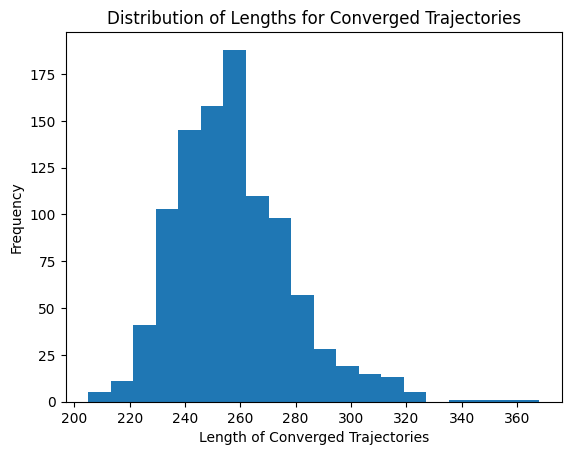

In [56]:
# Filter out the simulations that converged and extract the final strategy of each
finalXnisa = [Xntisa[n][-1] for n in range(num_simulations) if Cn[n]]
length_n = [len(Xntisa[n]) for n in range(num_simulations) if Cn[n]]

# Convert list of final strategies to a numpy array
finalXnisa = np.array(finalXnisa, dtype=object)

# Analyze the distribution of final strategies' lengths if necessary
plt.hist(length_n, bins=20)
plt.title('Distribution of Lengths for Converged Trajectories')
plt.xlabel('Length of Converged Trajectories')
plt.ylabel('Frequency')
plt.show()

In [57]:
non_converged_runs = np.where(np.logical_not(Cn))[0]
non_converged_runs

array([], dtype=int64)

In [58]:
if len(non_converged_runs) > 0:
    plt.plot(Xntisa[non_converged_runs[-1]][:, 1, :, 0], color='red', label='agent1')
    plt.plot(Xntisa[non_converged_runs[-1]][:, 0, :, 0], color='blue', label='agent0')
    plt.xlabel('time'); plt.ylabel('cooperation probability')

In [63]:
mae.obsdist(x)

Array([[0.07400903, 0.07400908, 0.04901669, 0.0490167 , 0.07400908,
        0.07400908, 0.0490167 , 0.0490167 , 0.04901672, 0.04901672,
        0.07795755, 0.07795755, 0.04901672, 0.04901672, 0.07795755,
        0.07795755],
       [0.10501501, 0.04995885, 0.10501502, 0.04995887, 0.04995887,
        0.04506724, 0.04995887, 0.04506724, 0.105015  , 0.04995887,
        0.105015  , 0.04995887, 0.04995887, 0.04506724, 0.04995887,
        0.04506724]], dtype=float32)

In [64]:
finalXnisa = []
length_n = []
for n in range(num_simulations):
    if Cn[n]:
        finalXnisa.append(Xntisa[n][-1])
        length_n.append(len(Xntisa[n]))
finalXnisa = np.array(finalXnisa)
finalXnisa.shape

(1000, 2, 16, 2)

In [65]:
finalRni = np.array([mae.Ri(Xisa) for Xisa in finalXnisa])

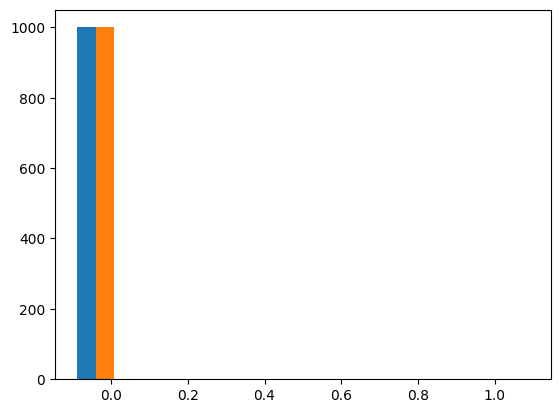

In [66]:
plt.hist([finalRni[:,0], finalRni[:,1]], range=(-0.1,1.1));

**Percentage going to cooperation:**

In [67]:
np.mean(finalRni[:,0] > 0.9) * 100

0.0

In [68]:
def load_simulation_data():
    # Load strategy time series and convergence data
    strategy_time_series = np.load('wolf_strategy_time_series_1000.npy', allow_pickle=True)
    return strategy_time_series

# Load the data
strategy_time_series = load_simulation_data()

Shape of the data for Agent 0: (2341, 2, 4, 2)
Shape of the data for Agent 1: (1941, 2, 4, 2)


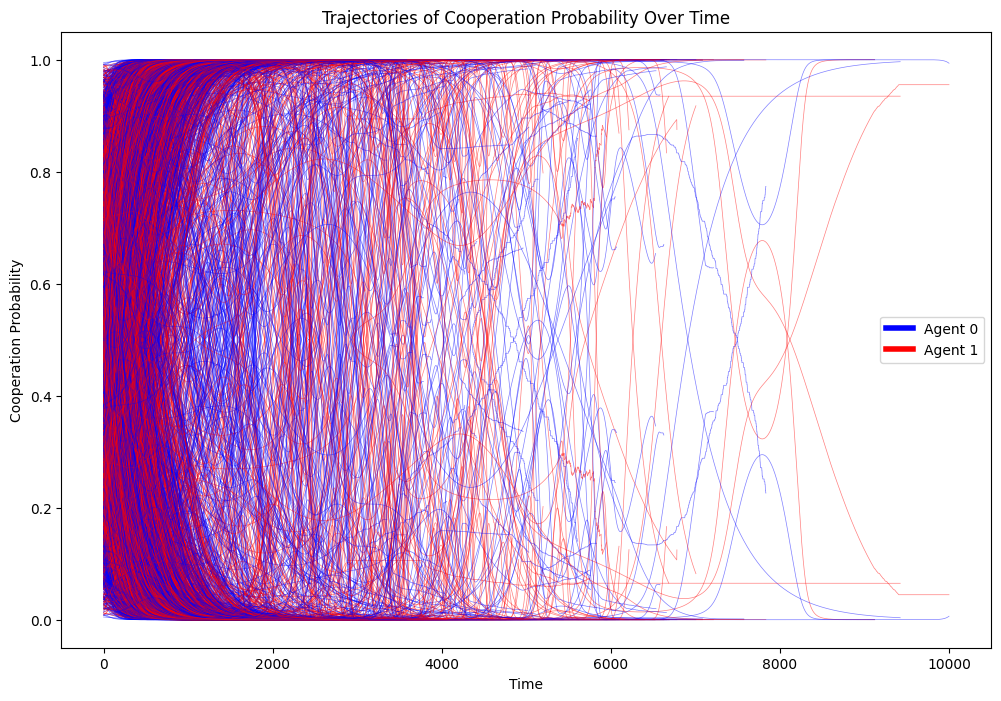

In [71]:
# Setup the plot
plt.figure(figsize=(12, 8))

# Define colors for clarity and reusability
colors = {'Agent 0': 'blue', 'Agent 1': 'red'}

# Check the shape of the data and print it
print("Shape of the data for Agent 0:", strategy_time_series[0].shape)
print("Shape of the data for Agent 1:", strategy_time_series[1].shape)

# Assume the data shape is (number of steps, number of variables, number of agents)
# We need to select which variable to plot, e.g., the first variable
variable_index = 0

# Loop through each simulation
for series in strategy_time_series:
    # Plot each trajectory for agent 0
    plt.plot(series[:, variable_index, 0], color=colors['Agent 0'], alpha=0.5, linewidth=0.5)
    # Plot each trajectory for agent 1
    plt.plot(series[:, variable_index, 1], color=colors['Agent 1'], alpha=0.5, linewidth=0.5)

# Adding plot labels and title
plt.xlabel('Time')
plt.ylabel('Cooperation Probability')
plt.title('Trajectories of Cooperation Probability Over Time')

# Create custom handles for the legend
custom_lines = [Line2D([0], [0], color=colors['Agent 0'], lw=4),
                Line2D([0], [0], color=colors['Agent 1'], lw=4)]

# Set the legend with custom handles
plt.legend(custom_lines, ['Agent 0', 'Agent 1'])

# Show the plot
plt.show()


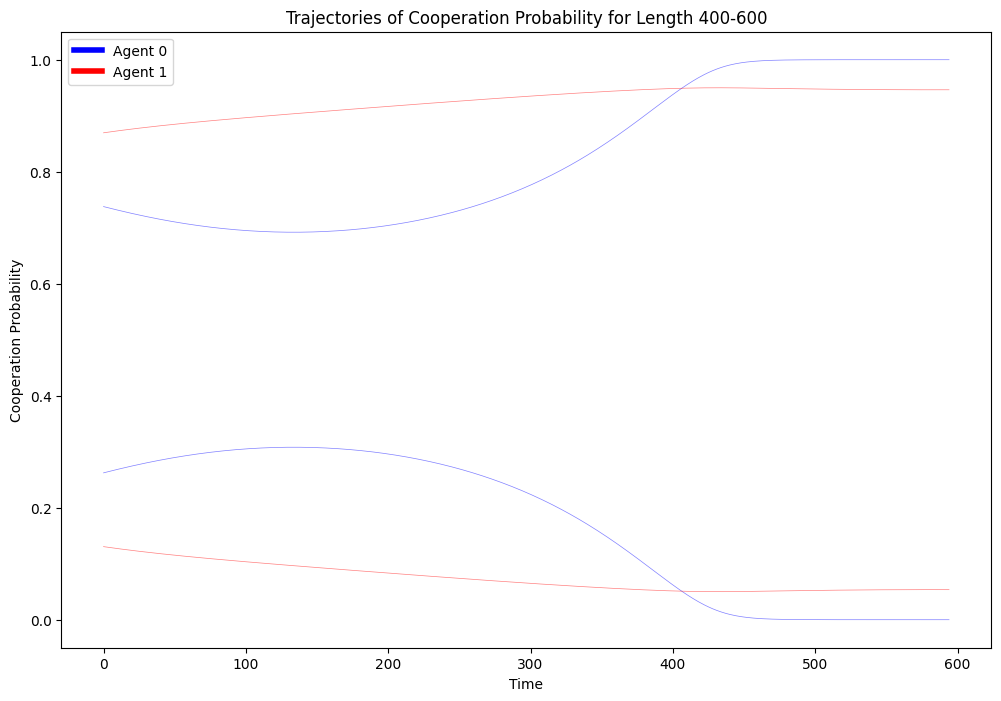

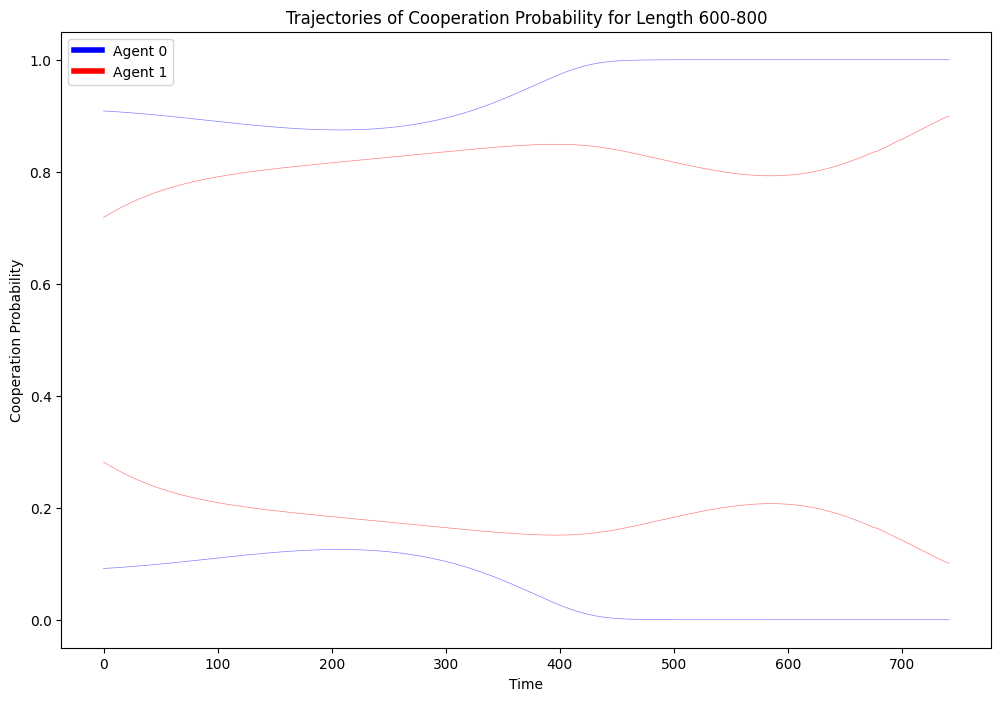

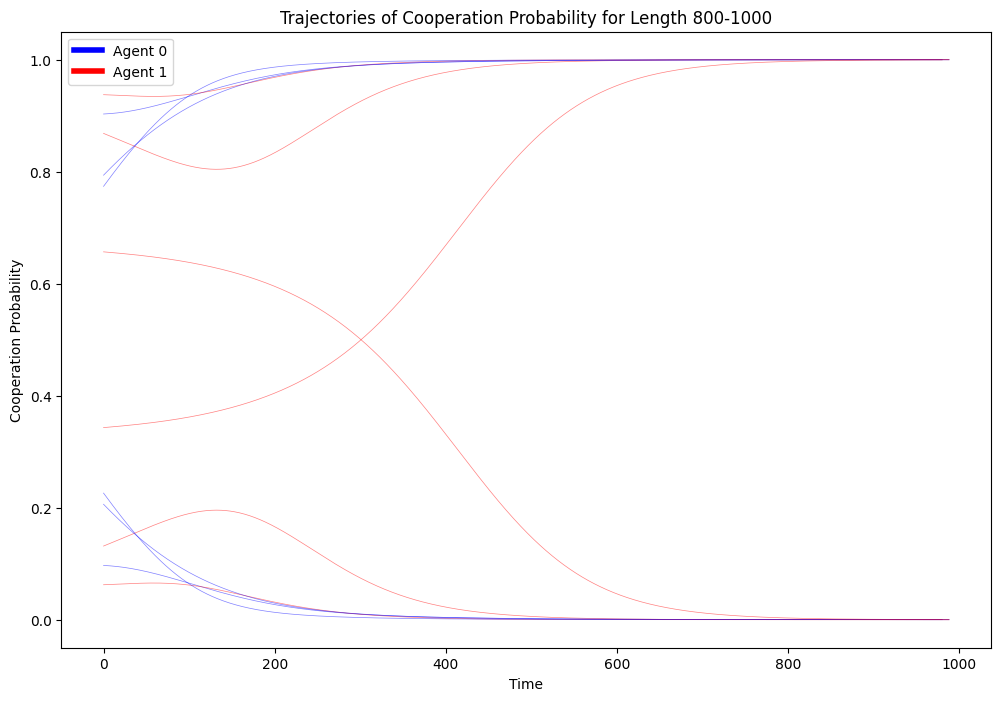

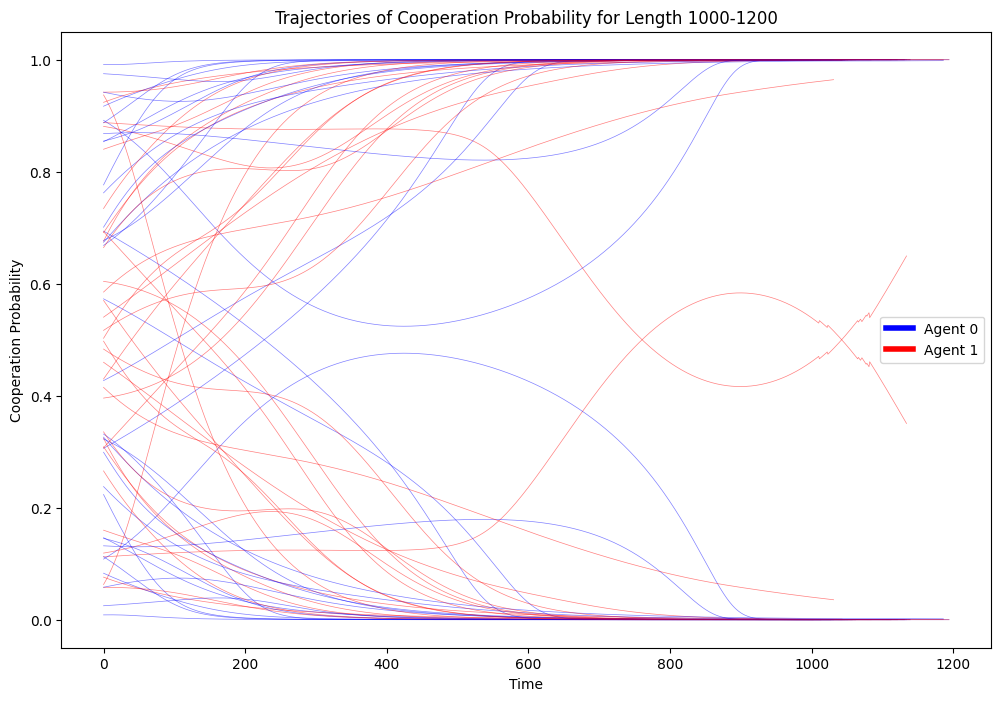

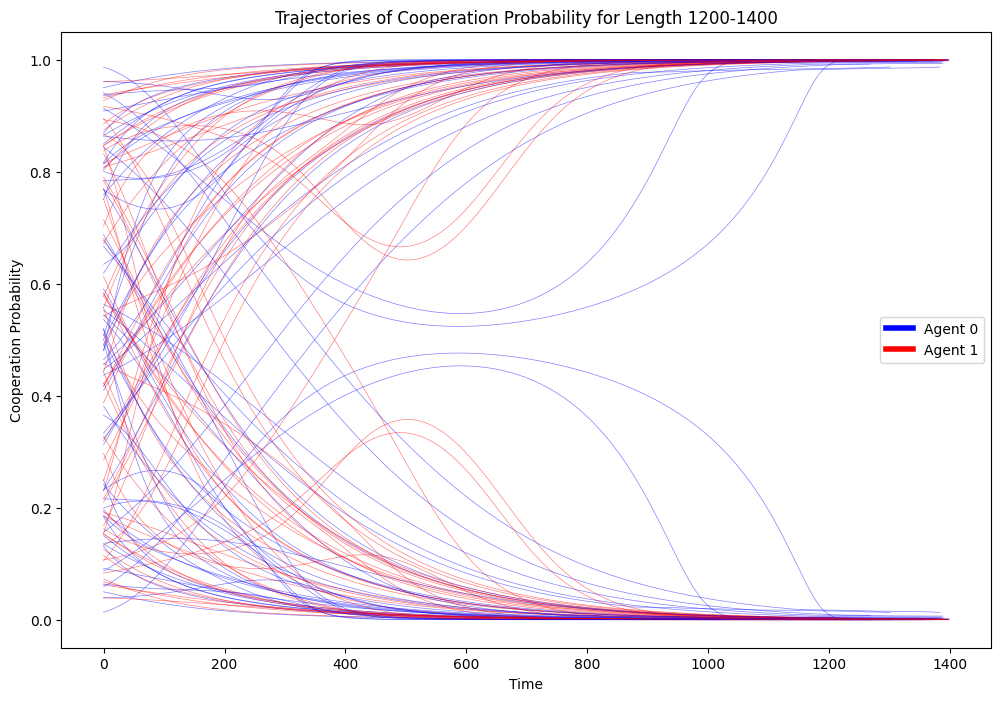

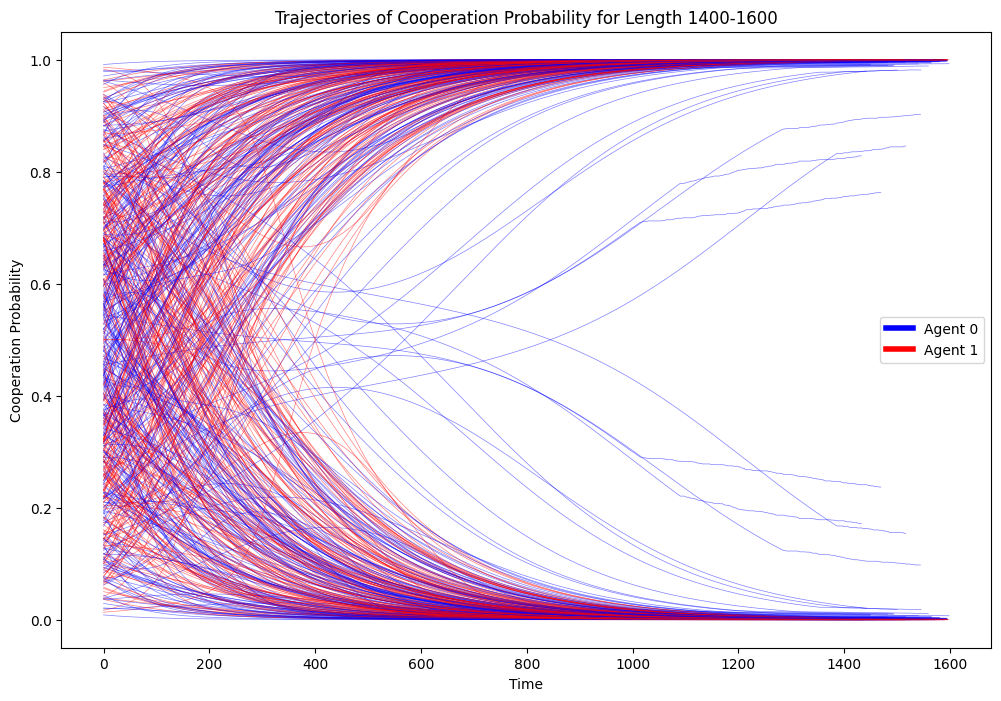

In [72]:
bins = [200, 400, 600, 800, 1000, 1200, 1400, 1600]
bin_labels = ['200-400', '400-600', '600-800', '800-1000', '1000-1200', '1200-1400', '1400-1600']

# Initialize a dictionary to hold categorized trajectories
categorized_trajectories = {label: [] for label in bin_labels}

# Categorize each trajectory based on its length
for series in strategy_time_series:
    length = len(series)
    for i, bin_edge in enumerate(bins):
        if length < bin_edge:
            category_label = bin_labels[i-1 if i != 0 else 0]
            categorized_trajectories[category_label].append(series)
            break

# Now, we have the trajectories categorized by length intervals
# Let's plot the trajectories for each interval
for category, trajectories in categorized_trajectories.items():
    if trajectories:  # Check if there are trajectories in this category
        plt.figure(figsize=(12, 8))
        plt.title(f'Trajectories of Cooperation Probability for Length {category}')
        plt.xlabel('Time')
        plt.ylabel('Cooperation Probability')
        
        for series in trajectories:
            plt.plot(series[:, variable_index, 0], color=colors['Agent 0'], alpha=0.5, linewidth=0.5)  # for Agent 0
            plt.plot(series[:, variable_index, 1], color=colors['Agent 1'], alpha=0.5, linewidth=0.5)  # for Agent 1
        
        plt.legend(custom_lines, ['Agent 0', 'Agent 1'])
        plt.show()
